# Python Data Analysis for Radiotherapy Applications

## Contents:
1. Dose map with gammas and protons in RT
2. PhSp files: reading IEAE and ROOT formats
4. GateTools: Gamma index
5. Same as 1. for internal RT

# Dose map analysis

In [55]:
import numpy as np
import SimpleITK as sitk

# Read a sitk image
img_ct = sitk.ReadImage('Ex_dose3D/data/patient-2mm.mhd')
# img_ct = sitk.ReadImage('Ex_InternalRT/data/patient_CT.mhd')
print('Image size: ', img_ct.GetSize())
print('Image spacing: ', img_ct.GetSpacing())
print('Image origin: ', img_ct.GetOrigin())

Image size:  (126, 126, 111)
Image spacing:  (2.0, 2.0, 2.0)
Image origin:  (0.0, 0.0, 0.0)


In [56]:
# Convert sitk image to a numpy array
arr_ct = sitk.GetArrayFromImage(img_ct)
print('Array size: ', arr_ct.shape, ' <--- be careful to the dimension order!)')

Array size:  (111, 126, 126)  <--- be careful to the dimension order!)


In [57]:
from ipywidgets import interact
# to enable interactive widgets in jupyter notebook run this command in a terminal:
#jupyter nbextension enable --py widgetsnbextension
import matplotlib.pyplot as plt
%matplotlib inline

def show_ct(sx,sy,sz):
    fig, ax = plt.subplots(1,3, figsize=(10, 5))
    ax[0].imshow(arr_ct[sx,:,:], origin='lower', cmap=plt.cm.gray)
    ax[1].imshow(arr_ct[:,sy,:], cmap=plt.cm.gray)
    ax[2].imshow(arr_ct[:,:,sz], cmap=plt.cm.gray)
    
interact(show_ct, sx=(0,arr_ct.shape[0]-1), sy=(0,arr_ct.shape[1]-1), sz=(0,arr_ct.shape[2]-1));

interactive(children=(IntSlider(value=55, description='sx', max=110), IntSlider(value=62, description='sy', ma…

# Exercise Ex_dose3D

# Run the GATE example and analyse the output
## some high statistic results with 1e6 particles are available in results/

In [59]:
img_dose = sitk.ReadImage('Ex_dose3D/results.1e6/3d-gamma-Dose.mhd')
# img_dose = sitk.ReadImage('Ex_InternalRT/results.1e6/out-Dose.mhd')
arr_dose = sitk.GetArrayFromImage(img_dose)
print('Image size = ', arr_dose.shape)
print('Image min and max: ',  np.amin(arr_dose), np.amax(arr_dose))

Image size =  (50, 50, 50)
Image min and max:  0.0 1.23685895e-05


In [60]:
filter = sitk.RescaleIntensityImageFilter()
filter.SetOutputMaximum(1.0)
filter.SetOutputMinimum(0.0)
img_dose = filter.Execute(img_dose)

In [61]:
arr_dose = sitk.GetArrayFromImage(img_dose)
print('Image size = ', arr_dose.shape)
print('Image min and max: ',  np.amin(arr_dose), np.amax(arr_dose))

Image size =  (50, 50, 50)
Image min and max:  0.0 1.0


In [62]:
def show_dose(nslice):
    plt.imshow(arr_dose[:,:,nslice], cmap=plt.cm.hot)
    plt.colorbar()
    
interact(show_dose, nslice=(0,arr_dose.shape[2]-1));

interactive(children=(IntSlider(value=24, description='nslice', max=49), Output()), _dom_classes=('widget-inte…

In [63]:
img_resampled_dose = sitk.Resample(img_dose, img_ct, sitk.Transform(), sitk.sitkLinear, 0)

In [64]:
arr_resampled_dose = sitk.GetArrayFromImage(img_resampled_dose)
print('Image size = ', arr_resampled_dose.shape)
print('Image min and max: ',  np.amin(arr_resampled_dose), np.amax(arr_resampled_dose))

Image size =  (111, 126, 126)
Image min and max:  0.0 0.976139


In [65]:
def show_fusion(nslice=64, opacity=0.7):
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.imshow(arr_ct[:,:,nslice], cmap=plt.cm.gray)
    a = arr_resampled_dose[:,:,nslice]
    b = np.ma.masked_where(a <= 0.001, a)
    plt.imshow(b, alpha=opacity, cmap=plt.cm.hot)
    plt.colorbar()
    
interact(show_fusion, nslice=(0,arr_ct.shape[2]-1), opacity=(0,1,0.1));

interactive(children=(IntSlider(value=64, description='nslice', max=125), FloatSlider(value=0.7, description='…

Questions:
- plot a depth dose profile
- display uncertainty map


# Phase-space (PhSp) analysis

# Reading IAEA phase-space files
You can get IAEA phase-space files from the IAEA database: https://www-nds.iaea.org/phsp/phsp.htmlx
* CyberKnife_IRIS
* ELEKTA_Precise
* SIEMENS_Primus
* Varian_Clinac
* Varian_TrueBeam

# Example with Varian phase-space file

In [11]:
import numpy as np

#For PHOTON and ELECTRON Varian Native File
dt=np.dtype([('p', np.int8), ('e', np.float32), ('x', np.float32), ('y', np.float32), ('z', np.float32), ('dx', np.float32), ('dy', np.float32)])

#For PHOTON an ELECTRON phase space actor output file (GATE) 
#dt=np.dtype([('p', np.int8), ('e', np.float32), ('x', np.float32), ('y', np.float32), ('z', np.float32), ('dx', np.float32), ('dy', np.float32), ('we', np.float32), ('inc', np.float32) ])

#Test on Reduced  phsp (fisrt particles)
data=np.fromfile('data/Varian_TrueBeam6MV_sample.IAEAphsp', dtype=dt, count=10000)
print('Number of particles:', len(data))
print(data)

# new_data=bytearray(data[1:1001])
# with open("data/Varian_TrueBeam6MV_test.IAEAphsp", "wb") as file:
#     file.write(new_data)

Number of particles: 1000
[(1, 0.415759,  8.64546e-01,  5.05857e+00, 27.3344,  3.02680e-02,  1.84434e-01)
 (1, 0.841563,  1.28558e+00, -2.70167e+00, 27.3259,  1.65588e-01, -1.75081e-01)
 (1, 1.76492 ,  3.59102e+00, -4.05766e+00, 27.2196,  1.31519e-01, -1.42818e-01)
 (1, 0.314953, -1.79705e+00,  5.35984e+00, 27.311 , -6.24210e-02,  1.88840e-01)
 (1, 0.657031,  5.50308e+00, -1.92551e+00, 27.0547,  1.99408e-01, -7.18120e-02)
 (1, 0.696822,  1.20234e+00, -2.12707e+00, 27.3278,  4.33290e-02, -7.79670e-02)
 (1, 0.632338, -6.37644e-01,  5.23750e+00, 27.3377, -1.88190e-02,  1.88766e-01)
 (1, 1.27944 , -1.77585e+00, -9.02747e-01, 27.3117, -4.86940e-02,  9.16830e-02)
 (1, 0.94072 ,  4.06056e+00,  2.37612e+00, 27.1855,  1.45005e-01,  8.43820e-02)
 (1, 0.9033  ,  1.24062e+00,  3.62524e+00, 27.327 ,  4.60730e-02,  1.30830e-01)
 (1, 1.72042 , -2.20763e-01,  1.92616e+00, 27.341 , -7.66500e-03,  6.80940e-02)
 (1, 0.394411, -4.92149e+00, -3.98135e+00, 27.1123, -2.24488e-01, -6.62515e-01)
 (1, 1.41596 ,

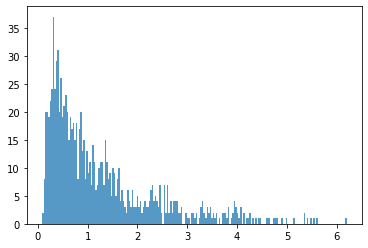

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot the Energy histogram
x = data['e']

n, bins, patches = plt.hist(x, bins=200, alpha=0.75)

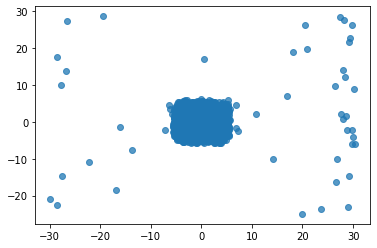

In [30]:
# Plot the particle positions
x = data['x']
y = data['y']

fig = plt.scatter(x, y, alpha=0.75)
# fig = plt.hist2d(x, y, bins=100)#, cmap=plt.cm.jet)

# Exercise Ex_PhSp

See https://davidsarrut.pages.in2p3.fr/gate-exercices-site/docs/exercice4/ for the documentation
and https://gitlab.in2p3.fr/davidsarrut/gate-exercices/-/tree/master/linac for the source code of the exercise

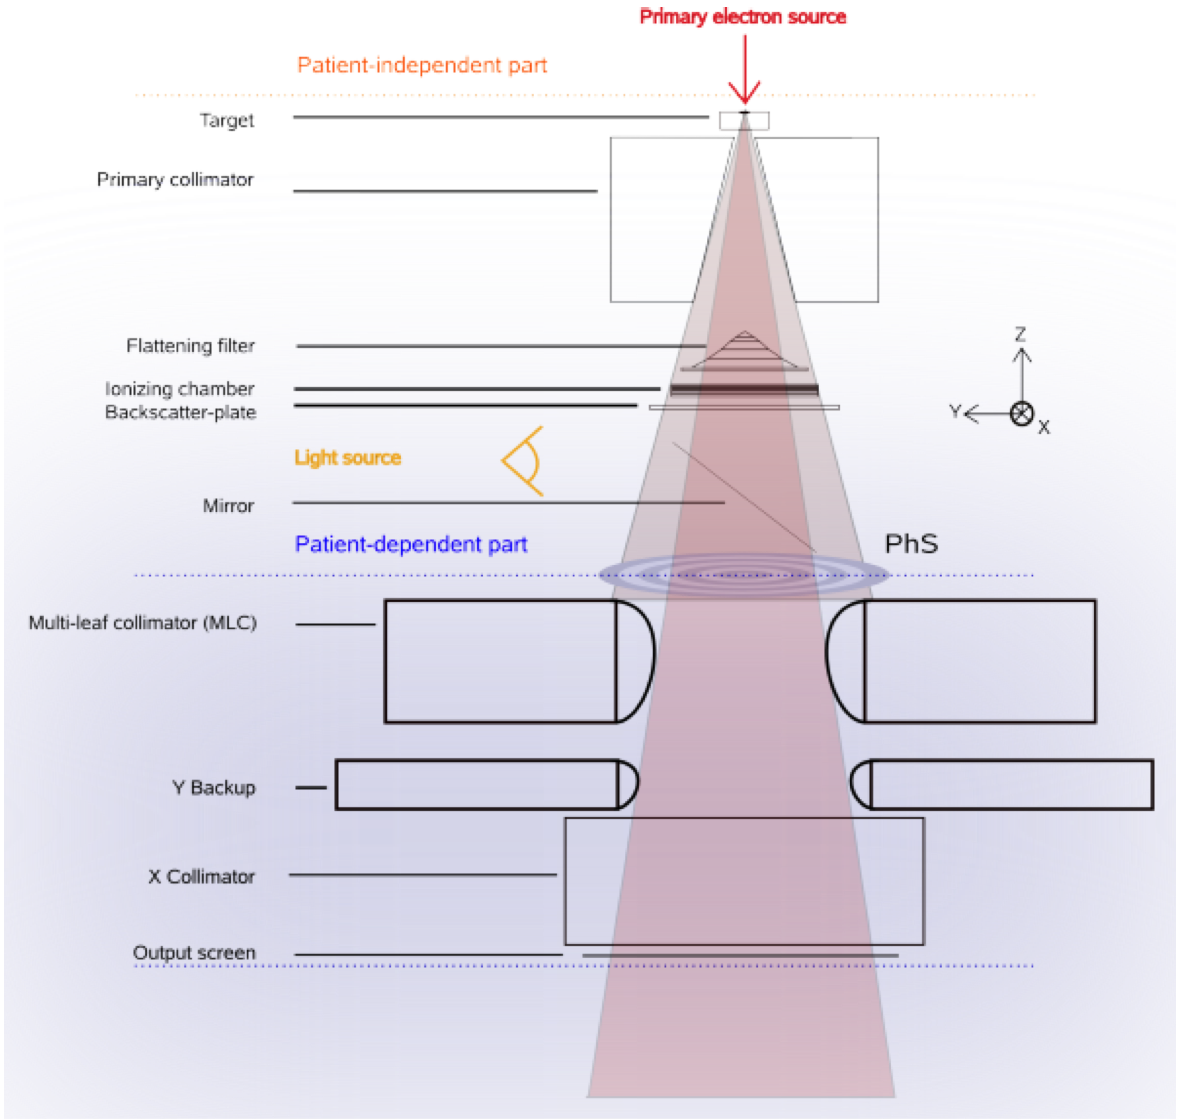

Use the output of the following simulation:
- Folder: Ex_PhSp/
- Already computed results in folder Ex_PhSp/results.MD6k/


In [22]:
import uproot

# read a PHSP
root_filename = 'Ex_PhSp/results.MD6k/output-PhS-g.root'
try:
    f = uproot.open(root_filename)
except Exception:
    print("File '"+root_filename+"' cannot be opened, not root file ?")
    exit()

# Look for a single key named "PhaseSpace"
k = f.keys()
try:
    psf = f['PhaseSpace']
except Exception:
    print("This root file is not a PhaseSpace, keys are: ", f.keys())
    exit()
    psf = f['PhaseSpace']
# now, the variable psf contains a root Tree with various branches: Energy, X, Y, Z etc
print('Read PHSP object', psf)
print("PhaseSpace keys: ", psf.keys())
# all branches are set in the variable 'a'
a = psf.arrays()

Read PHSP object <TTree b'PhaseSpace' at 0x7f8da6cd0320>
PhaseSpace keys:  [b'Ekine', b'Weight', b'X', b'Y', b'Z', b'dX', b'dY', b'dZ', b'TrackID', b'EventID', b'RunID']


Number of particles:  109619


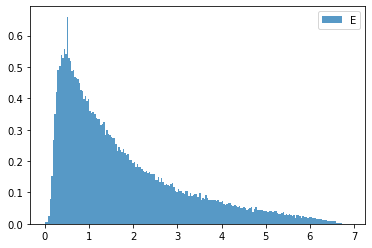

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot the E
nbs = 200
x = a[b'Ekine']
print('Number of particles: ', len(x))
n, bins, patches = plt.hist(x, nbs, density=True, alpha=0.75, label='E')
plt.legend()

Number of elements:  109619


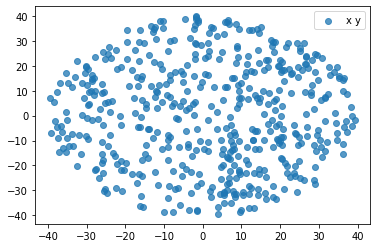

In [24]:
# Plot the X,Y 
nbs = 200
x = a[b'X']
y = a[b'Y']
print('Number of elements: ', len(x))
# only keep 500 first elements 
n = 500
x = x[:n]
y = y[:n]
plt.scatter(x, y, alpha=0.75, label='x y')
plt.legend()

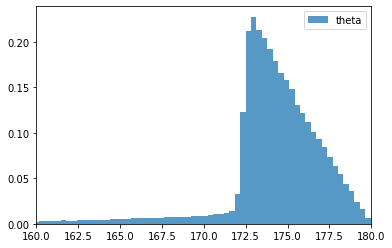

In [25]:
import numpy as np

# Plot the theta angle (main direction dZ
nbs = 500
x = np.rad2deg(np.arccos(a[b'dZ']))
n, bins, patches = plt.hist(x, nbs, density=True, alpha=0.75, label='theta')
plt.xlim(160,180)
plt.legend()

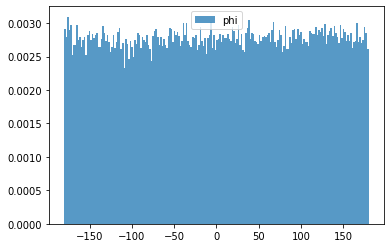

In [26]:
# Plot the phi angle
nbs = 200
x = np.rad2deg(np.arctan2(a[b'dY'], a[b'dX']))
n, bins, patches = plt.hist(x, nbs, density=True, alpha=0.75, label='phi')
plt.legend()

# Gamma index using GATE tools 

# Exercise Ex_internal-RT

## Run the GATE example to produce a dose map
## and use this notebook from the "dose map analysis" section
## to analyse the result